# New TDM client demo

### Download and filter metadata with Pandas

In [4]:
# Parameters:
dataset_id = "943b499d-2d00-e422-095f-97274a8b2121"

In [5]:
# Importing your dataset with a dataset ID
from tdm_package import tdm_client

dataset_metadata = tdm_client.get_metadata(dataset_id)

INFO:root:Downloading 943b499d-2d00-e422-095f-97274a8b2121 metadata to 943b499d-2d00-e422-095f-97274a8b2121.csv


100% |########################################################################|


In [7]:
import pandas as pd

In [8]:
df = pd.read_csv(dataset_metadata)

In [9]:
print('Total documents', len(df))

Total documents 1734


In [10]:
dataset_document_count = len(df)
print("Total documents", dataset_document_count)

Total documents 1734


In [11]:
# Set the pandas option to show all columns
pd.set_option("max_columns", None) 

df.head() # Show the first five rows of our DataFrame

,id,title,isPartOf,publicationYear,doi,docType,provider,datePublished,issueNumber,volumeNumber,url,creator,publisher,language,pageStart,pageEnd,placeOfPublication,wordCount,pageCount,outputFormat
0,http://www.jstor.org/stable/2871374,Subject Index,Shakespeare Quarterly,1997,NaN,article,jstor,1997-01-01,5.0,48,http://www.jstor.org/stable/2871374,NaN,Folger Shakespeare Library,eng,840,848,NaN,6128,9,unigram; bigram; trigram
1,http://www.jstor.org/stable/2868641,Reviews of Books Previously Recorded in Shakes...,Shakespeare Quarterly,1973,NaN,article,jstor,1973-10-01,4.0,24,http://www.jstor.org/stable/2868641,Bruce Nesbitt,Folger Shakespeare Library,eng,564,574,NaN,4875,11,unigram; bigram; trigram
2,http://www.jstor.org/stable/2867059,Will and Reason in Troilus and Cressida,Shakespeare Quarterly,1961,NaN,article,jstor,1961-07-01,3.0,12,http://www.jstor.org/stable/2867059,David Kaula,Folger Shakespeare Library,eng,271,283,NaN,7137,13,unigram; bigram; trigram
3,http://www.jstor.org/stable/2866396,Pepys' Shakespeare Song,Shakespeare Quarterly,1955,NaN,article,jstor,1955-04-01,2.0,6,http://www.jstor.org/stable/2866396,MacDonald Emslie,Folger Shakespeare Library,eng,159,170,NaN,4210,12,unigram; bigram; trigram
4,http://www.jstor.org/stable/2871079,[H],Shakespeare Quarterly,1964,NaN,article,jstor,1964-01-01,NaN,15,http://www.jstor.org/stable/2871079,NaN,Folger Shakespeare Library,eng,88,112,NaN,13450,25,unigram; bigram; trigram


In [12]:
id_list = df['id'].tolist()

In [13]:
'http://www.jstor.org/stable/2871420' in id_list

True

In [14]:
id_list

['http://www.jstor.org/stable/2871374',
 'http://www.jstor.org/stable/2868641',
 'http://www.jstor.org/stable/2867059',
 'http://www.jstor.org/stable/2866396',
 'http://www.jstor.org/stable/2871079',
 'http://www.jstor.org/stable/2870303',
 'http://www.jstor.org/stable/2870754',
 'http://www.jstor.org/stable/2870928',
 'http://www.jstor.org/stable/24778435',
 'http://www.jstor.org/stable/2869302',
 'http://www.jstor.org/stable/2869196',
 'http://www.jstor.org/stable/2869529',
 'http://www.jstor.org/stable/2871235',
 'http://www.jstor.org/stable/24778492',
 'http://www.jstor.org/stable/2871043',
 'http://www.jstor.org/stable/2871330',
 'http://www.jstor.org/stable/2867101',
 'http://www.jstor.org/stable/2870902',
 'http://www.jstor.org/stable/2866046',
 'http://www.jstor.org/stable/2868374',
 'http://www.jstor.org/stable/2902227',
 'http://www.jstor.org/stable/2866520',
 'http://www.jstor.org/stable/2870461',
 'http://www.jstor.org/stable/2869789',
 'http://www.jstor.org/stable/2866693'

In [15]:
# Drop each of these named columns
df = df.drop(['outputFormat', 'pageEnd', 'pageStart', 'datePublished', 'language'], axis=1)

In [16]:
# Drop articles without an author
df = df.dropna(subset=['creator'])

In [17]:
print("Original total", dataset_document_count)
print("Filtered total", len(df))

Original total 1734
Filtered total 1627


In [18]:
# Examples for filtering the data based on the values found under 'title'

df = df[df.title != 'Review Article'] # Remove articles with title "Review Article"
df = df[df.title != 'Front Matter'] # Remove articles with title "Front Matter"
df = df[df.title != 'Back Matter'] # Remove articles with title "Back Matter"

# Remove articles with fewer than 3000 words, adjust or remove

df = df[df.wordCount > 3000] 

In [19]:
print("Original total", dataset_document_count)
print("Filtered total", len(df))

Original total 1734
Filtered total 1627


In [20]:
filtered_id_list = df["id"].tolist()

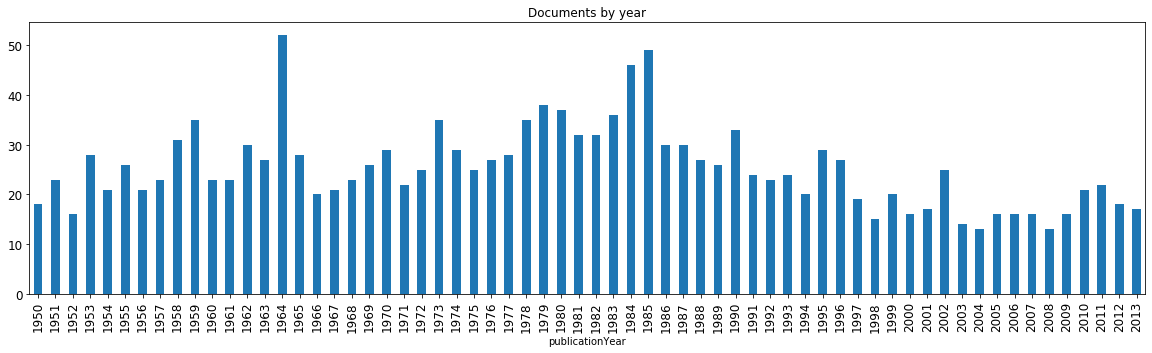

In [21]:
df.groupby(['publicationYear'])['id'].agg('count').plot.bar(title='Documents by year', figsize=(20, 5), fontsize=12); 

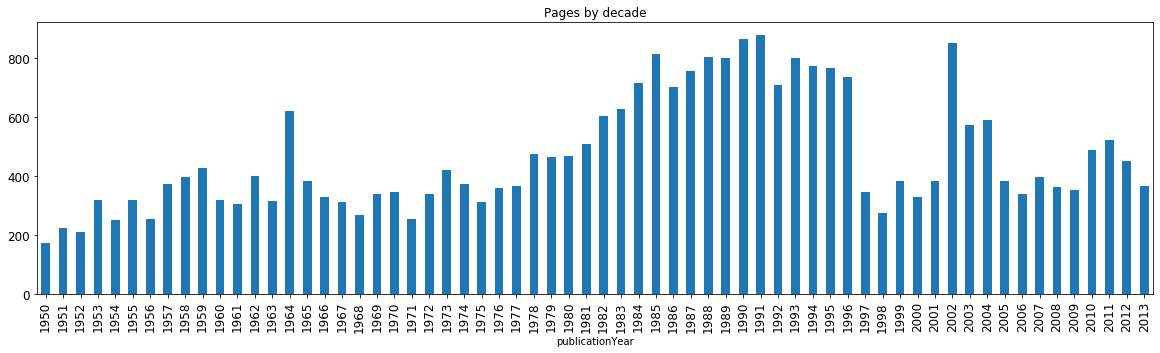

In [22]:
df.groupby(['publicationYear'])['pageCount'].agg('sum').plot.bar(title='Pages by decade', figsize=(20, 5), fontsize=12);

### Count word frequencies

In [23]:
dataset_json_file = tdm_client.get_dataset(dataset_id)

INFO:root:Downloading 943b499d-2d00-e422-095f-97274a8b2121 to 943b499d-2d00-e422-095f-97274a8b2121.jsonl.gz


100% |########################################################################|


In [24]:
import json
import gzip
from collections import Counter

word_frequency = Counter()

In [25]:
with gzip.open(dataset_json_file, "rb") as input_file:
    for row in input_file:
        document = json.loads(row)
        _id = document["id"]
        if _id in filtered_id_list:
            unigrams = document.get("unigramCount", [])
            for gram, count in unigrams.items():
                word_frequency[gram] += count

In [34]:
word_frequency

Counter({'Oaths': 5,
         'in': 311834,
         "Shakespeare's": 25588,
         'Henry': 14217,
         'VI': 1800,
         'Plays': 2971,
         'FAYE': 1,
         'L.': 6800,
         'KELLY': 3,
         'HEN': 20,
         'Pistol': 157,
         'said': 2264,
         'to': 284149,
         'Bardolph,': 98,
         '"A': 3474,
         'sword': 564,
         'is': 142172,
         'an': 46636,
         'oath,': 84,
         'and': 453621,
         'oaths': 117,
         'must': 9333,
         'have': 36580,
         'their': 27064,
         'course"': 29,
         '(Henry': 380,
         'V),': 101,
         'he': 54936,
         'was': 53625,
         'stating': 80,
         'not': 54171,
         'only': 17384,
         'a': 222937,
         'common': 2431,
         'Elizabethan': 6248,
         'belief,': 65,
         'but': 37585,
         'also': 17461,
         'principle': 720,
         'of': 598581,
         'Shakespearean': 5057,
         'dramatic': 5525,
   

In [26]:
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

the                  784139
of                   598581
and                  453621
in                   311834
to                   284149
a                    222937
is                   142172
that                 137824
by                   125010
as                   118857
for                  109523
The                  98741
his                  94046
with                 84731
on                   72620
at                   59063
he                   54936
not                  54171
from                 53808
was                  53625
it                   52865
Shakespeare          49357
pp.                  48730
be                   48446
an                   46636


In [27]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [28]:
transformed_word_frequency = Counter()

In [29]:
for document in tdm_client.dataset_reader(dataset_json_file):
    _id = document["id"]
    if _id in filtered_id_list:
        unigrams = document.get("unigramCount", [])
        for gram, count in unigrams.items():
            clean_gram = gram.lower()
            if clean_gram in stop_words:
                continue
            transformed_word_frequency[clean_gram] += count
        break

In [35]:
transformed_word_frequency

Counter({'oaths': 33,
         "shakespeare's": 12,
         'henry': 58,
         'vi': 16,
         'plays': 12,
         'faye': 1,
         'l.': 1,
         'kelly': 1,
         'hen': 1,
         'pistol': 2,
         'said': 1,
         'bardolph,': 1,
         '"a': 2,
         'sword': 1,
         'oath,': 14,
         'must': 4,
         'course"': 1,
         '(henry': 1,
         'v),': 1,
         'stating': 1,
         'common': 5,
         'elizabethan': 11,
         'belief,': 2,
         'also': 2,
         'principle': 1,
         'shakespearean': 1,
         'dramatic': 11,
         'construction.': 3,
         'drama': 2,
         'life,': 2,
         'oath': 75,
         'calls': 1,
         'action.': 3,
         'drama,': 3,
         'whenever': 1,
         'character': 8,
         'swears': 4,
         'something': 2,
         'something,': 1,
         'plot': 2,
         'takes': 3,
         'form': 1,
         'direct': 1,
         'result': 4,
         'regar

In [30]:
for gram, count in transformed_word_frequency.most_common(25):
    print(gram.ljust(20), count)

oath                 75
henry                58
shakespeare          43
york                 35
oaths                33
.                    33
broken               22
allegiance           20
scene                19
henry's              19
edward               17
warwick              17
vi                   16
i.                   16
act                  15
oath,                14
god                  14
king,                14
one                  13
york,                13
(v.                  13
shakespeare's        12
plays                12
king                 12
vow                  12


In [31]:
df = pd.DataFrame(list(transformed_word_frequency.items())[:25], columns=["ngram", "count"])

In [36]:
df.head()

,ngram,count
0,oaths,33
1,shakespeare's,12
2,henry,58
3,vi,16
4,plays,12


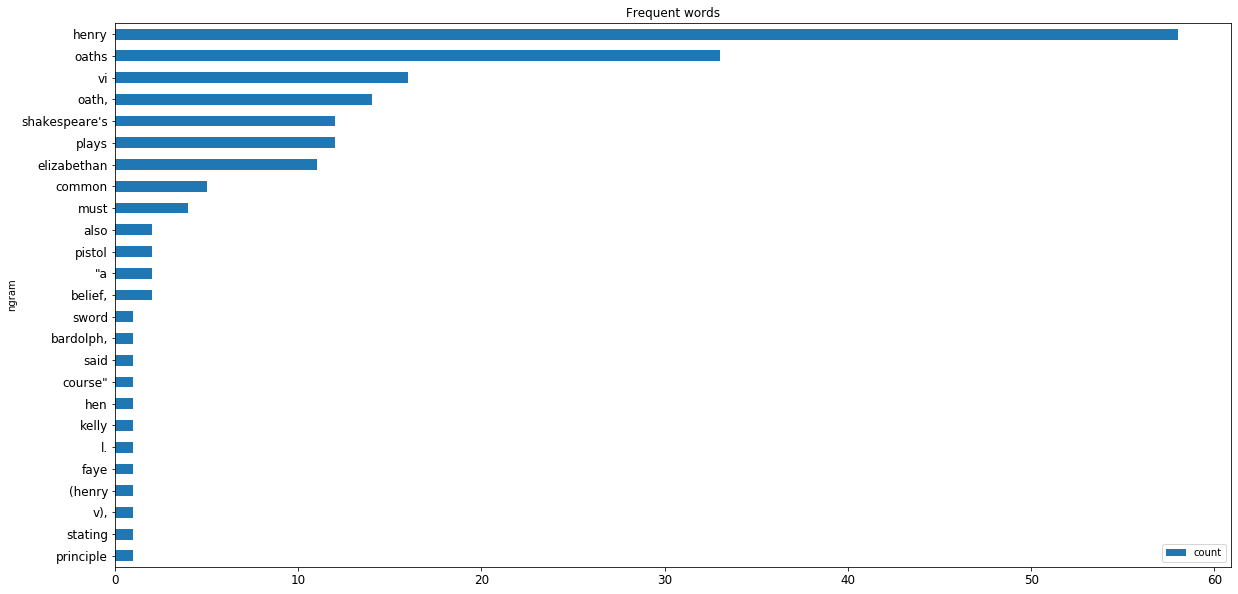

In [33]:
df.sort_values('count', ascending=True).plot.barh(title='Frequent words', figsize=(20, 10), fontsize=12, x="ngram", y="count");

### Significant terms

Run TFIDF on the first 10 documents in the filtered corpus.

In [37]:
def process_token(token):
    token = token.lower()
    if token in stop_words:
        return
    if len(token) < 4:
        return
    if not(token.isalpha()):
        return
    return token

In [38]:
import gensim

In [39]:
# Limit to n documents. Set to None to do all

limit = 500

n = 0
documents = []
for document in tdm_client.dataset_reader(dataset_json_file):
    processed_document = []
    _id = document["id"]
    if _id in filtered_id_list:
        unigrams = document.get("unigramCount", [])
        for gram, count in unigrams.items():
            clean_gram = process_token(gram)
            if clean_gram is None:
                continue
            processed_document.append(clean_gram)
        if len(processed_document) > 0:
            documents.append(processed_document)
        n += 1
        if (limit is not None) and (n >= limit):
           break

In [40]:
dictionary = gensim.corpora.Dictionary(documents)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(71783 unique tokens: ['abhoreth', 'abroad', 'accepted', 'accompanied', 'accompanies']...) from 500 documents (total 709499 corpus positions)


In [41]:
dict(list(dictionary.token2id.items())[0:10]) # Print the first ten tokens and their associated IDs.


{'abhoreth': 0,
 'abroad': 1,
 'accepted': 2,
 'accompanied': 3,
 'accompanies': 4,
 'accomplished': 5,
 'accordyng': 6,
 'account': 7,
 'accusation': 8,
 'accuse': 9}

In [42]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [43]:
model = gensim.models.TfidfModel(bow_corpus)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 500 documents and 71783 features (681632 matrix non-zeros)


In [44]:
corpus_tfidf = model[bow_corpus]

In [45]:
rows = []
for doc in corpus_tfidf:
    for term_id, score in doc:
        rows.append([dictionary.get(term_id), score])

In [46]:
df = pd.DataFrame(rows, columns=["ngram", "score"])

In [47]:
df.head()

,ngram,score
0,abhoreth,0.054538
1,abroad,0.027820
2,accepted,0.011958
3,accompanied,0.016082
4,accompanies,0.025295


In [48]:
df.describe()

,score
count,681132.000000
mean,0.022158
std,0.015591
min,0.000042
25%,0.010503
50%,0.018708
75%,0.030281
max,0.249867


In [49]:
top_50 = df.sort_values("score", ascending=False).head(n=50)

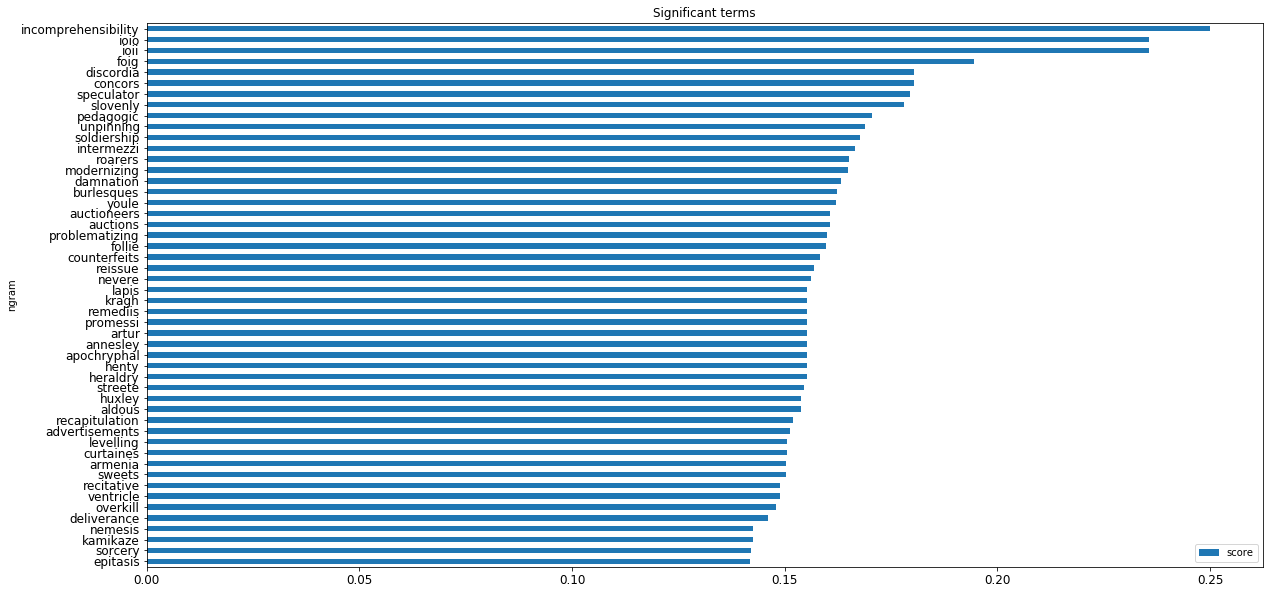

In [50]:
top_50.sort_values("score", ascending=True).plot.barh(title='Significant terms', figsize=(20, 10), fontsize=12, x="ngram", y="score");

 ### LDA topic modeling

In [ ]:
doc_count = len(id_list)
num_topics = 7 # Change the number of topics

# Remove terms that appear in less than 10% of documents and more than 75% of documents.
dictionary.filter_extremes(no_below=10 * .10, no_above=0.75)


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [ ]:
# Train the LDA model.
model = gensim.models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics
)

In [ ]:
for topic_num in range(0, num_topics):
    word_ids = model.get_topic_terms(topic_num)
    words = []
    for wid, weight in word_ids:
        word = dictionary.id2token[wid]
        words.append(word)
    print("Topic {}".format(str(topic_num).ljust(5)), " ".join(words))